<img width="150" alt="Logo_ER10" src="https://user-images.githubusercontent.com/3244249/151994514-b584b984-a148-4ade-80ee-0f88b0aefa45.png">

### Interpreting a leaf identification model with LIME
This notebook demonstrates the use of DIANNA with the LIME method on the [leafsnap30 image dataset](https://zenodo.org/record/5061353#.YeUwXy1Q30o). A pre-trained neural network classifier is used,
which identifies the species of leaf based on an image of it. 

LIME (Local Interpretable Model-agnostic Explanations) is an explainable-AI method that aims to create an interpretable model that locally represents the classifier. For more details see the [LIME paper](https://arxiv.org/abs/1602.04938).

*NOTE*: This tutorial is still work-in-progress, the final results need to be improved by tweaking the LIME parameters

#### 1. Imports and paths

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import dianna
from dianna import visualization

In [2]:
true_species = 'acer_rubrum'
image_path = Path('data', f'leafsnap_example_{true_species}.jpg')
model_path = Path('models', 'leafsnap_model.onnx')
model_classes_path = Path('data' ,'leafsnap_classes.csv')

#### 2. Loading the data
Two files are loaded here:
1. A file containg the numerical index that belongs to each class (=species of leaf). This is used so we know which output of the neural network corresponds to the class we want to run LIME on.
2. An image of a leaf, belonging to the Acer Rubrum species.

DIANNA requires input in numpy format, so the .jpg image is loaded and converted into a numpy array. The pixel values are then converted to the 0-1 range, which the classifier requires.
Finally, DIANNA requires the presence of a batch axis, and it needs to know where the batch and colour channel axes are located in the input data.

In [3]:
# load the model class definitions
class_to_idx = dict(np.genfromtxt(model_classes_path, dtype=None, encoding=None, delimiter=','))
true_species = 'acer_rubrum'
true_species_index = class_to_idx[true_species]

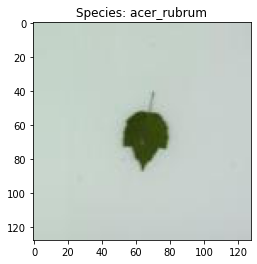

In [4]:
# load and plot the example image
img = np.array(Image.open(Path('data', f'leafsnap_example_{true_species}.jpg')))

plt.imshow(img)
plt.title(f'Species: {true_species}');

# the model expects float32 values in the 0-1 range for each pixel, with the colour channels as first axis
# the .jpg file has 0-255 ints with the channel axis last so it needs to be changed
input_data = img.transpose(2, 0, 1).astype(np.float32) / 255.

# define axis labels. Required is the channels axis
# in this example image, the channels axis is the first axis
axis_labels = {0: 'channels'}

#### 3. Applying LIME with DIANNA
The simplest way to run DIANNA on image data is with `dianna.explain_image`. The arguments are:
* The path to the model in ONNX format
* The image we want to explain
* The name of the explainable-AI method we want to use, here LIME
* The location of the batch and colour channel axes in the data
* The numerical indices of the classes we want an explanation for

In [5]:
# An explanation is returned for each label, but we ask for just one label so the output is a list of length one.
explanation_heatmap = dianna.explain_image(model_path, input_data, 'LIME', axis_labels=axis_labels, labels=[true_species_index])[0]

  0%|          | 0/5000 [00:00<?, ?it/s]

#### 4. Visualization
DIANNA includes a visualization package, capable of overlaying the explanation heatmap on the original input image.  
In this visualization, important superpixels are red, while less important superpixels are blue.

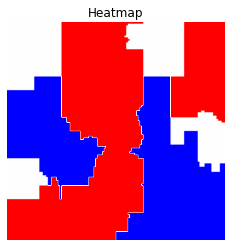

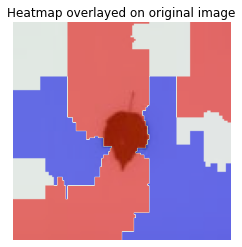

In [6]:
visualization.plot_image(explanation_heatmap, show_plot=False, heatmap_cmap='bwr')
plt.title('Heatmap')
plt.axis('off')

visualization.plot_image(explanation_heatmap, original_data=img, show_plot=False, heatmap_cmap='bwr')
plt.title('Heatmap overlayed on original image')
plt.axis('off')

plt.show()

The output heatmap is not very informative, there are only a few large blocks without much detail.  
We can run LIME again with some customized values for some of the options. These options can be given to `dianna.explain_image` and will automatically be used by LIME.  
We will change two things:
* Increase the number of features from the default 10 to 30
* Change the colour of superpixels that are turned "off" by LIME to white (Default = average of surrounding superpixels)

In [7]:
explanation_heatmap_customized = dianna.explain_image(model_path, input_data, 'LIME', axis_labels=axis_labels, labels=[true_species_index],
                                                      hide_color=1., num_features=30, num_samples=1000)[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

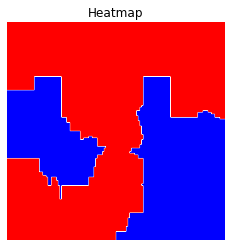

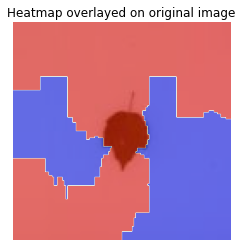

In [8]:
visualization.plot_image(explanation_heatmap_customized, show_plot=False, heatmap_cmap='bwr')
plt.title('Heatmap')
plt.axis('off')

visualization.plot_image(explanation_heatmap_customized, original_data=img, show_plot=False, heatmap_cmap='bwr')
plt.title('Heatmap overlayed on original image')
plt.axis('off')

plt.show()